### PREPARE LIBRARY, AND PARAMETERS

In [2]:
%pip install -q git+https://github.com/tensorflow/examples.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

# UNCOMMENT THIS IF YOU USE GOOGLE COLAB
from google.colab import drive

%matplotlib inline

In [4]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  1


In [5]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
SEG_DATASET = "dataset/seg_dataset"
BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2

DATASET_DIR = "dataset/dataset_segmented"
TEST_PREDICT_DIR = "test_predict/"
BATCH_SIZE = 18

IMG_HEIGHT = 128
IMG_WIDTH = 128
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.experimental.AUTOTUNE

# SEGMENTATION UNET

### LOAD AND SPLIT DATASET UNET

In [7]:
# #Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/original/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
# print(len(image_path))
# print(image_path[1])

# #Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/mask/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
# print(len(mask_path))
# print(mask_path[1])

In [8]:
#USE THIS IF YOU USE GOOGLE COLAB
#Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.1/segmentation_dataset/original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.1/segmentation_dataset/mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

print(len(image_path))
print(image_path[1])

print(len(mask_path))
print(mask_path[1])

1055
/content/drive/MyDrive/Skripsi/v_0.0.1/segmentation_dataset/original/SID1354_jpg.rf.9d555775cf172911b37e13a44d8bfde2.jpg
1055
/content/drive/MyDrive/Skripsi/v_0.0.1/segmentation_dataset/mask/SID1354_jpg.rf.9d555775cf172911b37e13a44d8bfde2.jpg


In [9]:
# images = []
# for path in image_path:
#     img = tf.io.read_file(path)
#     img_array = tf.image.decode_png(img, channels=3, dtype=tf.uint8)
#     images.append(img_array)

# masks = []
# for path in mask_path:
#     mask = tf.io.read_file(path)
#     mask_array = tf.image.decode_png(mask, channels=1, dtype=tf.uint8)
#     masks.append(mask_array)

In [10]:
#USE THIS IF YOU USE GOOGLE COLAB
masks = []
for path in tqdm(mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_jpeg(mask, channels=1)
    masks.append(mask_array)

images = []
for path in tqdm(image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_jpeg(img, channels=3)
    images.append(img_array)

100%|██████████| 1055/1055 [00:09<00:00, 115.56it/s]


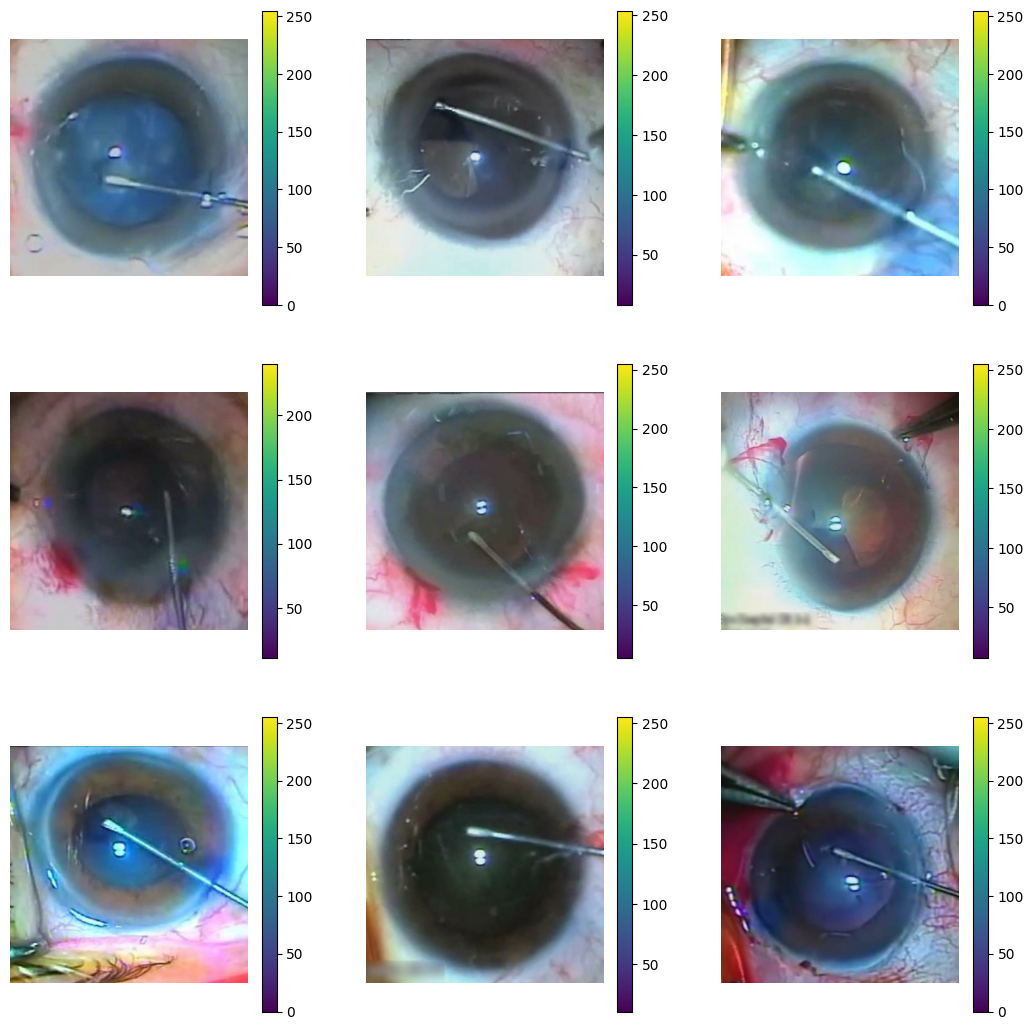

In [11]:
#Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

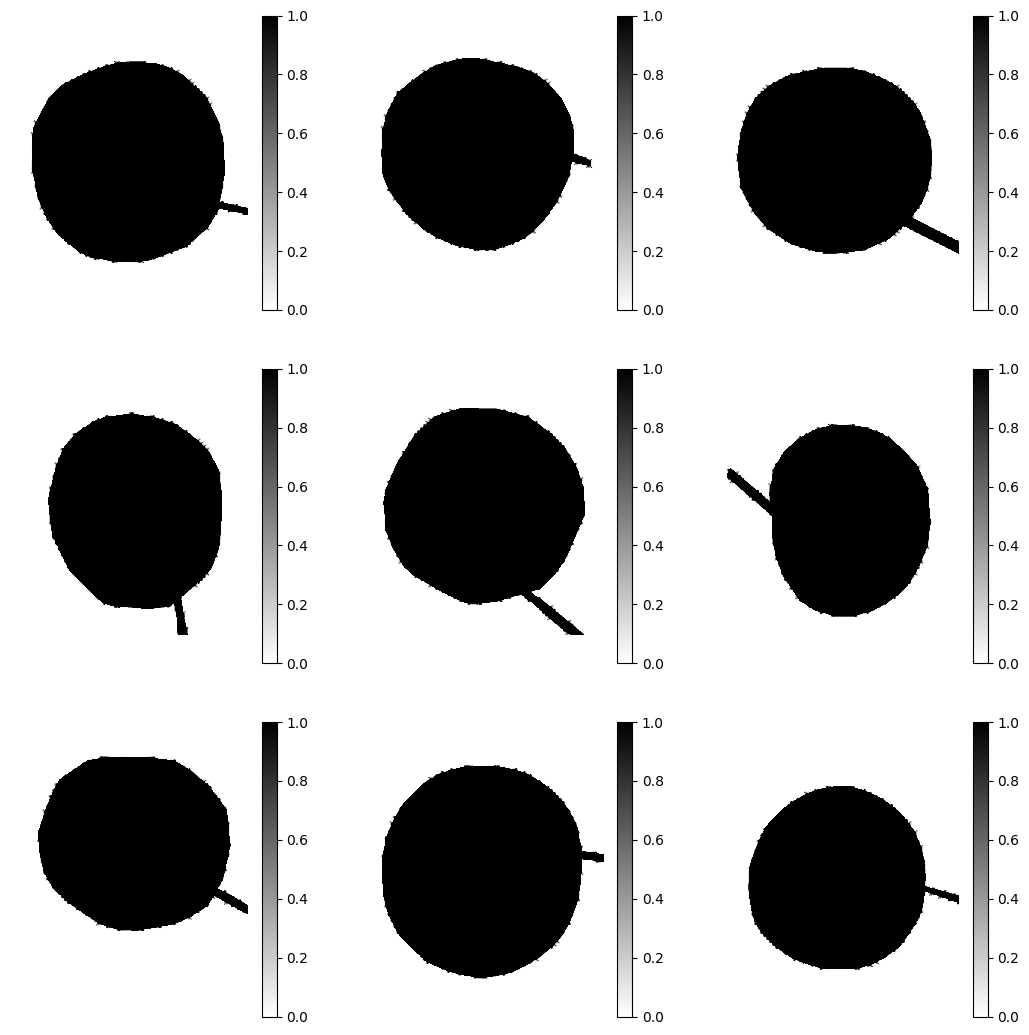

In [12]:
#Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

In [13]:
#Resize Dataset OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Dataset Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

In [ ]:
#visualizing a resized image and respective mask
# plot an image
plt.imshow(X[36])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

In [14]:
#Split Dataset into 80/20 Ratio
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=123)

#Make Dataset into Tensorflow Dataset
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

### DATA AUGMENTATION UNET

In [15]:
def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [16]:
# Zip Dataset
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# Perform Data Augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

In [17]:
train = train.cache().shuffle(1000).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

### BUILD MODEL UNET

In [18]:
base = keras.applications.DenseNet121(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False, weights='imagenet')

In [19]:
skip_layer_names = [
    'conv1/relu', # size 64*64
    'pool2_relu',  # size 32*32
    'pool3_relu',  # size 16*16
    'pool4_relu',  # size 8*8
    'relu'        # size 4*4
]

In [20]:
skip_outputs = [base.get_layer(name).output for name in skip_layer_names]

downstack = keras.Model(inputs=base.input, outputs=skip_outputs)

downstack.trainable = False

In [21]:
upstack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
inputs = keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

down = downstack(inputs)
out = down[-1]

skips = reversed(down[:-1])

for up, skip in zip(upstack, skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

out = keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same')(out)

unet = keras.Model(inputs=inputs, outputs=out)

In [23]:
unet.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=80 // BATCH_SIZE_SEG,
    validation_steps=20 // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2
)

### EVALUATE MODEL UNET (NO FINE-TUNING)

1/1 [==============================] - 3s 3s/step


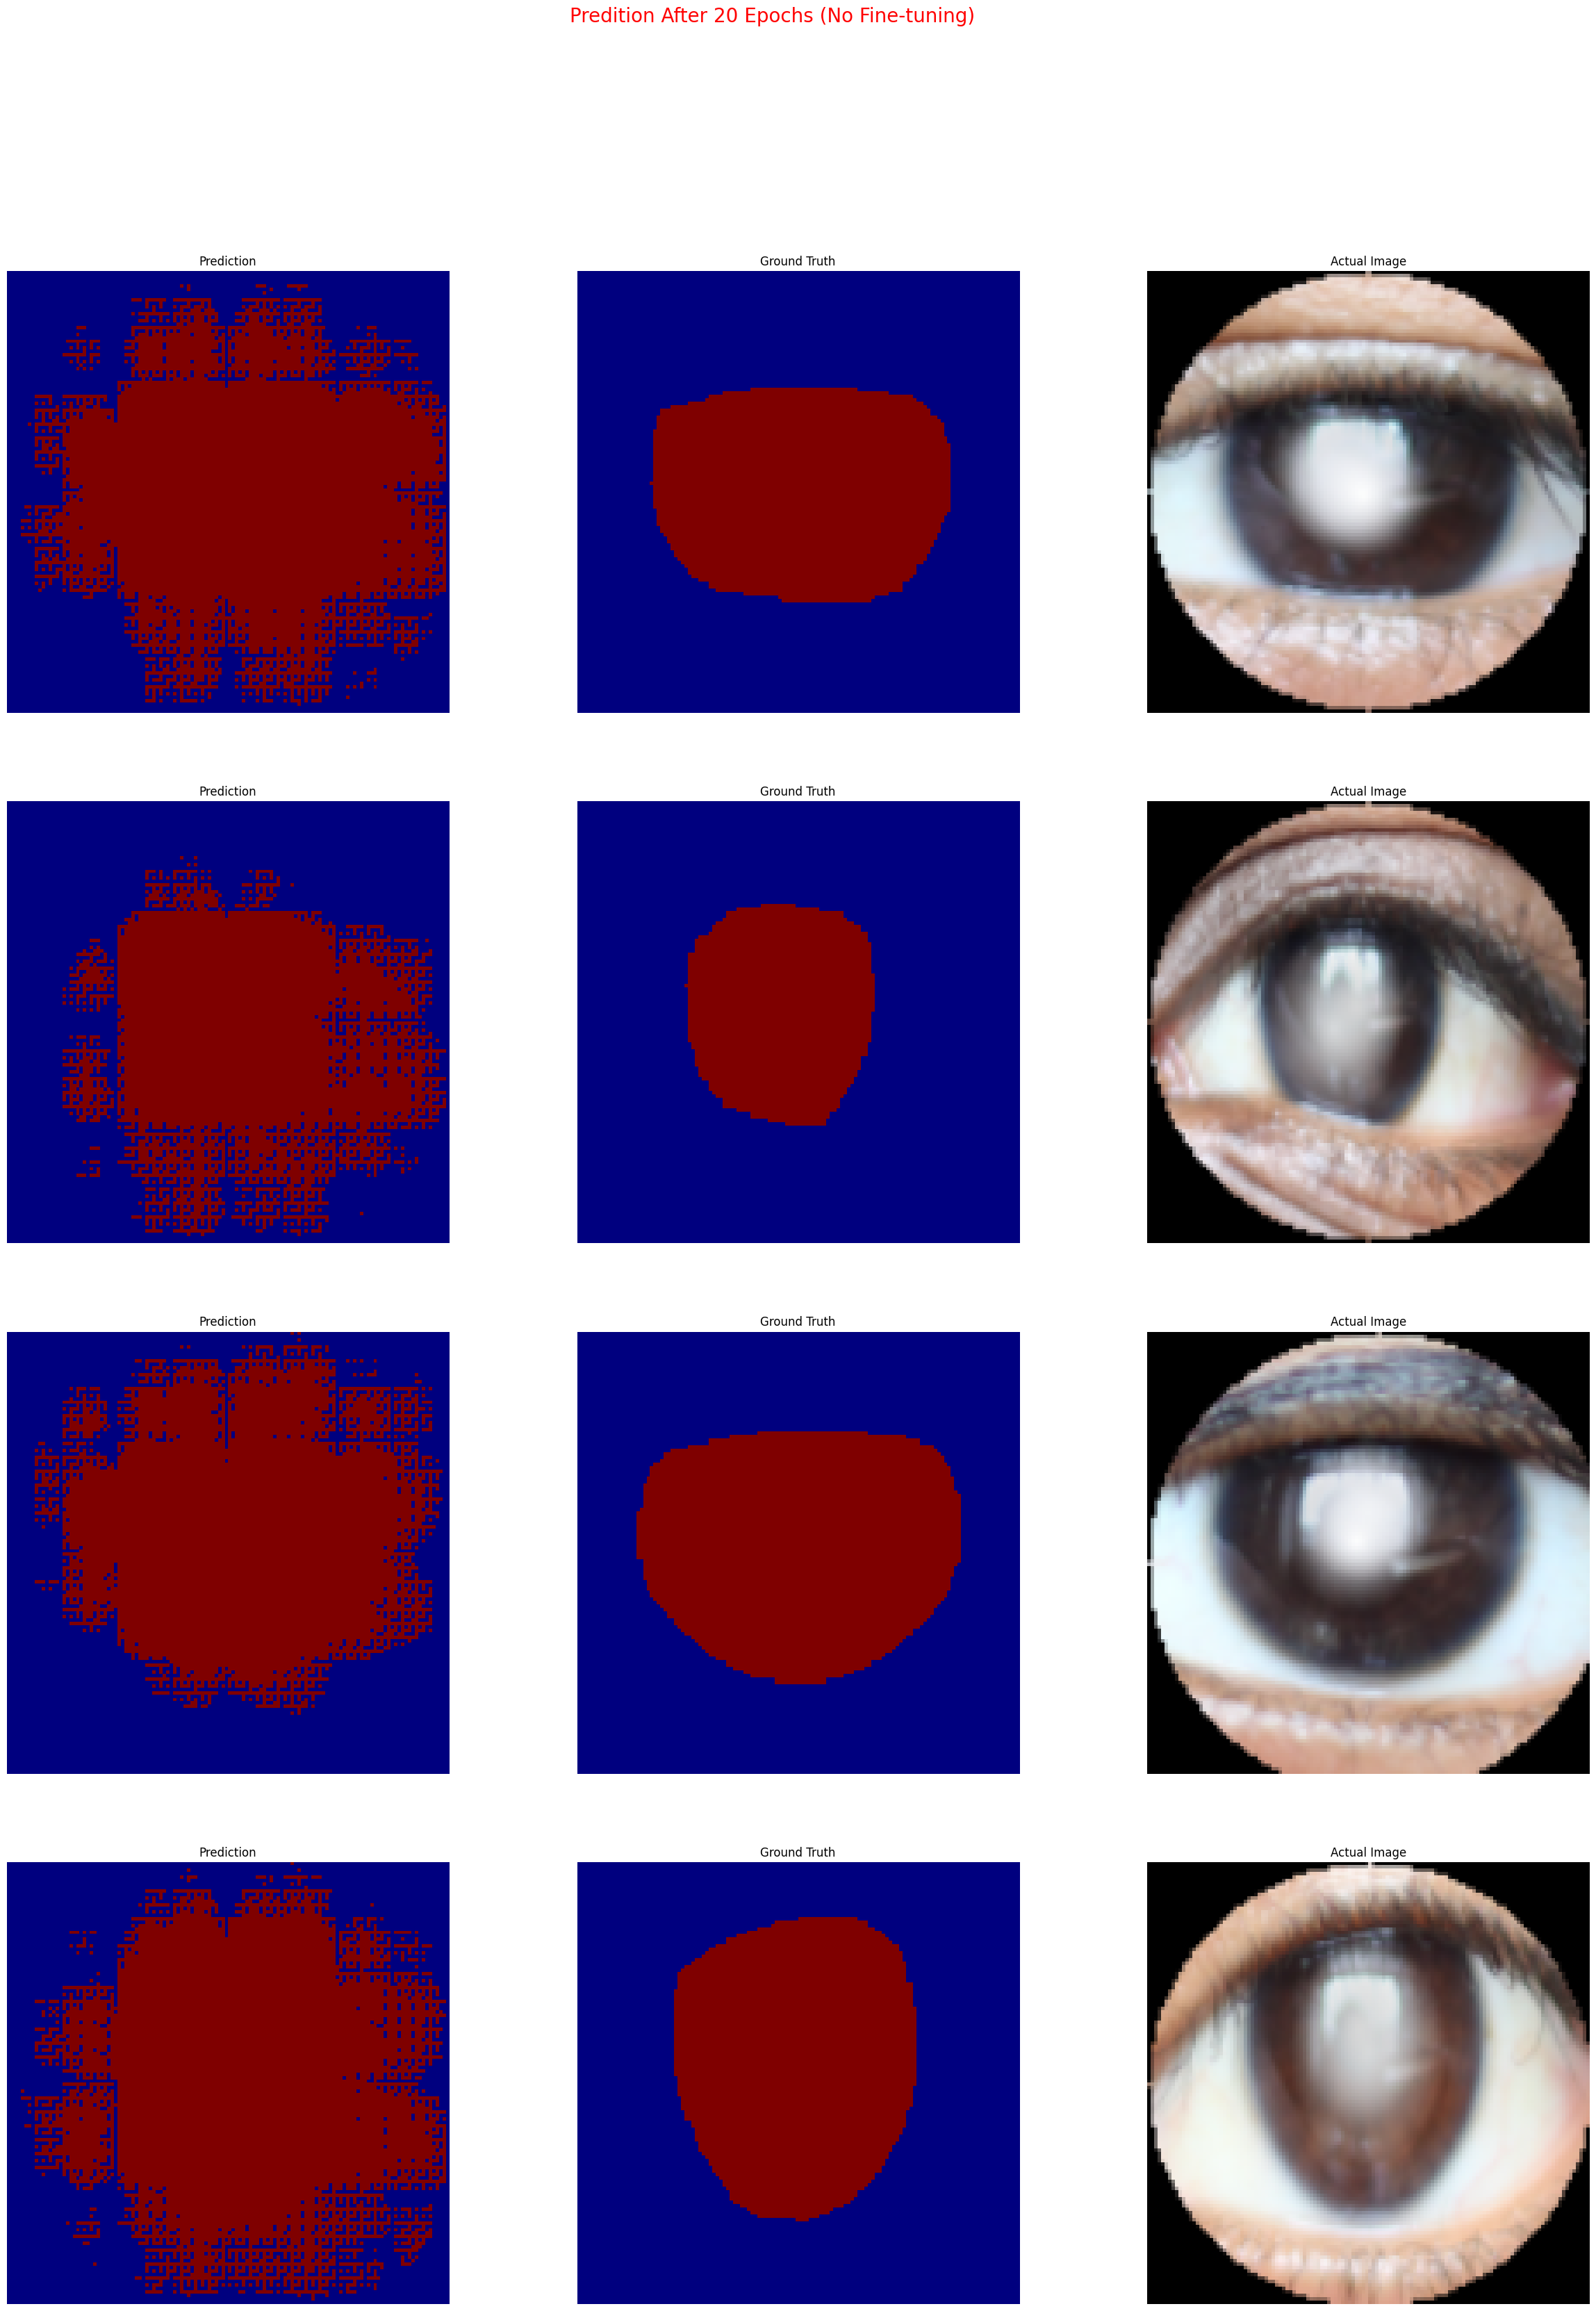

In [ ]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction With No Fine-tuning', color='red', size=20)
plt.show()

### FINE-TUNING

In [ ]:
downstack.trainable = True
# compile again
unet.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train from epoch 41 to 80
hist_2 = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=int(len(image_path) - (len(image_path) * VAL_RATIO_SEG)) // BATCH_SIZE_SEG,
    validation_steps=int(len(image_path) * VAL_RATIO_SEG) // BATCH_SIZE_SEG,
    epochs=100,
    initial_epoch = 50,
    verbose = 2
)

Epoch 51/100
10/10 - 36s - loss: 1.5708 - accuracy: 0.8246 - val_loss: 5.3372 - val_accuracy: 0.2119 - 36s/epoch - 4s/step
Epoch 52/100
10/10 - 5s - loss: 1.2229 - accuracy: 0.8693 - val_loss: 2.9832 - val_accuracy: 0.5765 - 5s/epoch - 460ms/step
Epoch 53/100
10/10 - 5s - loss: 1.3855 - accuracy: 0.8467 - val_loss: 2.5904 - val_accuracy: 0.6765 - 5s/epoch - 471ms/step
Epoch 54/100
10/10 - 5s - loss: 1.1607 - accuracy: 0.8830 - val_loss: 3.2462 - val_accuracy: 0.5867 - 5s/epoch - 498ms/step
Epoch 55/100
10/10 - 5s - loss: 1.1817 - accuracy: 0.8691 - val_loss: 4.8338 - val_accuracy: 0.2733 - 5s/epoch - 498ms/step
Epoch 56/100
10/10 - 5s - loss: 1.1442 - accuracy: 0.8758 - val_loss: 2.7819 - val_accuracy: 0.6324 - 5s/epoch - 503ms/step
Epoch 57/100
10/10 - 5s - loss: 1.2299 - accuracy: 0.8744 - val_loss: 5.3803 - val_accuracy: 0.2243 - 5s/epoch - 496ms/step
Epoch 58/100
10/10 - 5s - loss: 1.5025 - accuracy: 0.8596 - val_loss: 4.4959 - val_accuracy: 0.1828 - 5s/epoch - 492ms/step
Epoch 59/

1/1 [==============================] - 0s 133ms/step


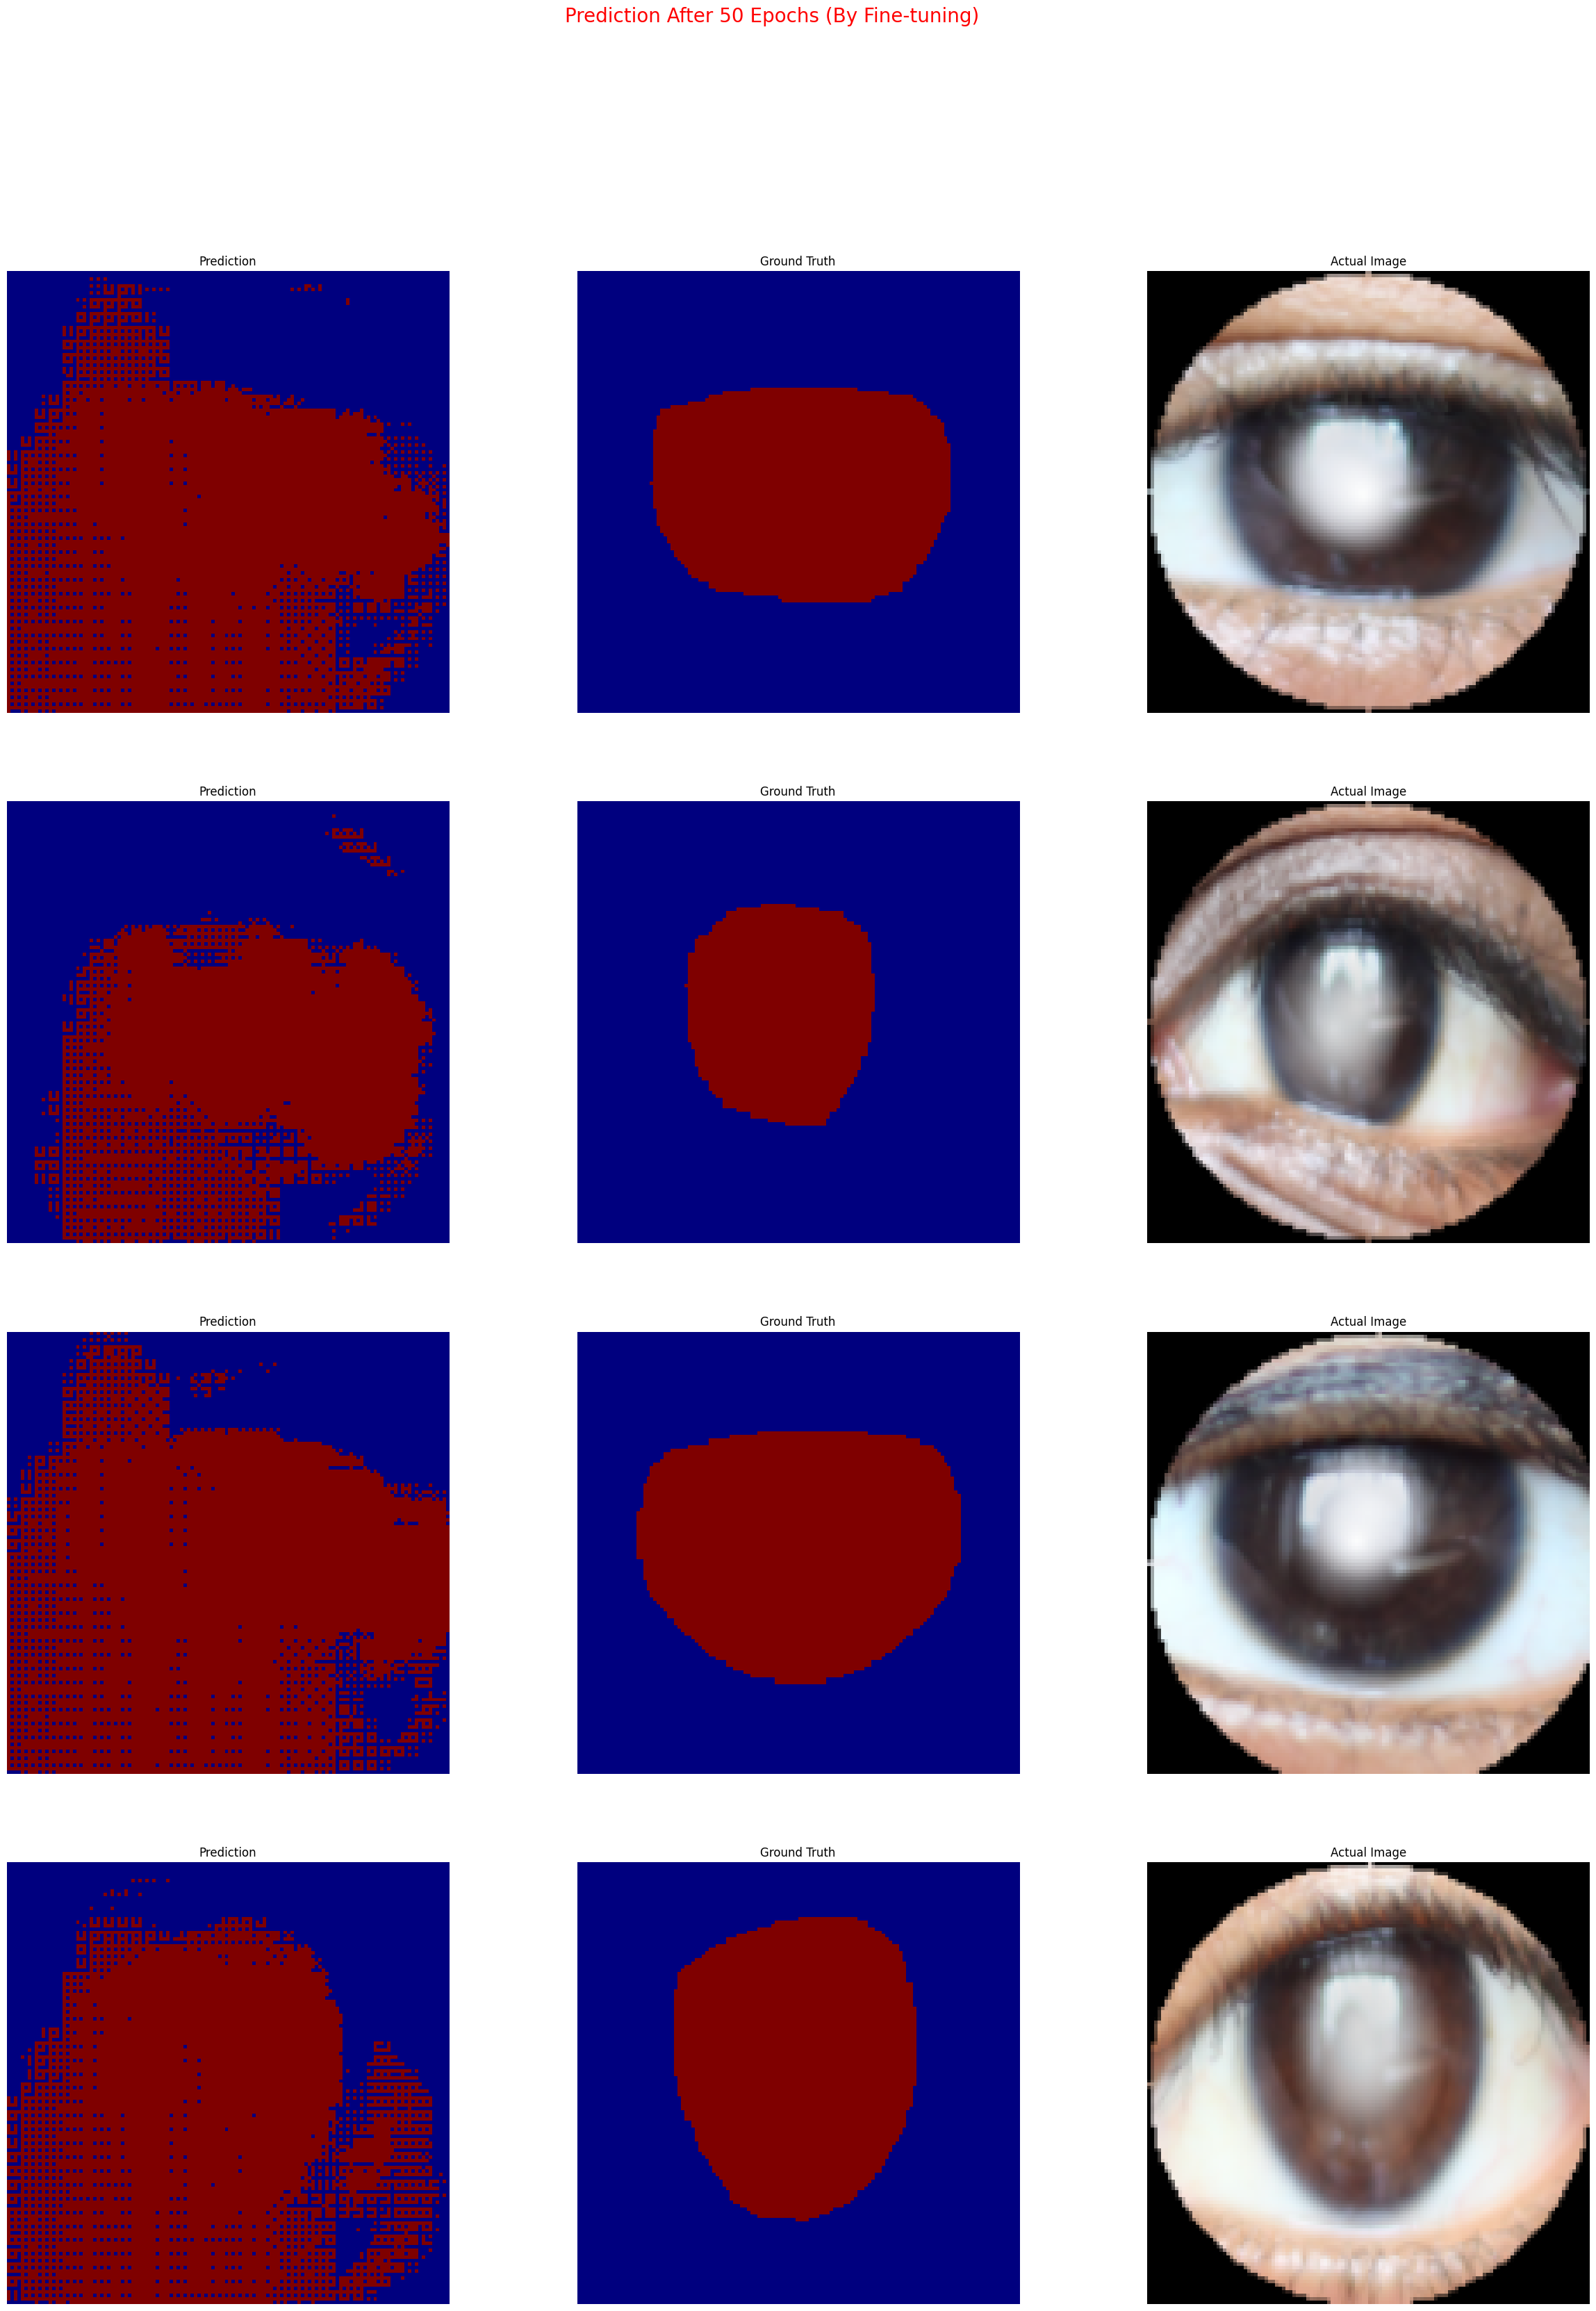

In [ ]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction After Fine-tuning', color='red', size=20)
plt.show()

## CLASSIFICATION CNN

### LOAD AND SPLIT DATASET CNN

In [ ]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### DATA AUGMENTATION & PIPELINING

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [ ]:
train_ds = train_ds.cache().shuffle(len(np.concatenate([i for x, i in train_ds]))).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CALLBACK

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.85):
            print("\nReached choosen accuracy so cancelling training!")
            self.model.stop_training = True

### MODEL

In [ ]:
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[myCallback()]
)

### EVALUATE MODEL

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_true = np.concatenate([i for x, i in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=-1)

conf_mat = confusion_matrix(y_true, y_pred)

In [ ]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
show_confusion_matrix(conf_mat, class_names)

### PREDICT

In [ ]:
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [ ]:
for filename in os.listdir(TEST_DIR):
    img = keras.preprocessing.image.load_img(TEST_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)

    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)